<a href="https://colab.research.google.com/github/kavita1910/Time-Series-forecasting-using-Tensorflow/blob/main/time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting in Tensorflow
#### What is a Time Series problem?

>Time series problems deals with data over time.

Problem types :
* Classification - output is in Discrete form (a label)
* Forecasting - output is in Continuous form (a number)

In forecasting the price of **Bitcoin**, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

In [ ]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data 

Since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Get the prices of Bitcoin from 03 November 2014 to 01 October 2021.

### Importing time series data with Pandas

In [ ]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2014-11-03_2021-11-02-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166
2014-11-07,BTC,346.77500,336.58500,351.57500,336.02833


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2556 entries, 2014-11-03 to 2021-11-02
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2556 non-null   object 
 1   Closing Price (USD)  2556 non-null   float64
 2   24h Open (USD)       2556 non-null   float64
 3   24h High (USD)       2556 non-null   float64
 4   24h Low (USD)        2556 non-null   float64
dtypes: float64(4), object(1)
memory usage: 119.8+ KB


In [ ]:
len(df)

2556

**Note :** The frequency at which a time series value is collected is often referred to as seasonality. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months).

Type of Time Series :
* Trend - Time series has a clear long-term increase or decrease (may or may not be linear).
* Seasonal - time series affected by seasonal factors such as time of the year (e.g. increase sales towards end of the year) or day or week.
* Cyclic - time series shows rise and falls over an unfixed period these tend to be longer/more variable than seasonal patterns

In [ ]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


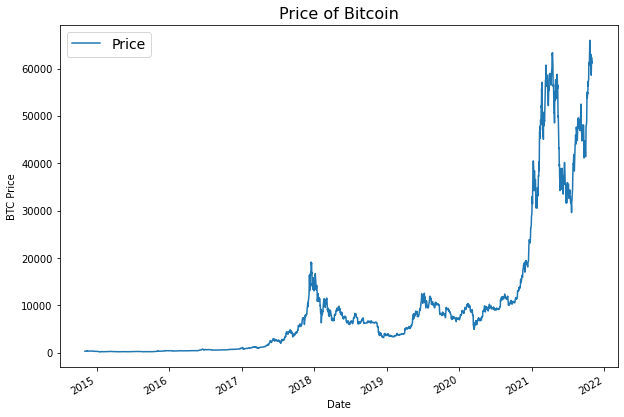

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin", fontsize=16)
plt.legend(fontsize=14);

### Importing time series data with Python's CSV module
You can use Python's in-built `csv module`. And if you're working with dates, you might also want to use Python's datetime.

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2014-11-03_2021-11-02-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 11, 3, 0, 0),
  datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0)],
 [331.60083,
  324.71833,
  332.45666,
  336.585,
  346.775,
  344.81166,
  343.065,
  358.50166,
  368.07666,
  376.99666])

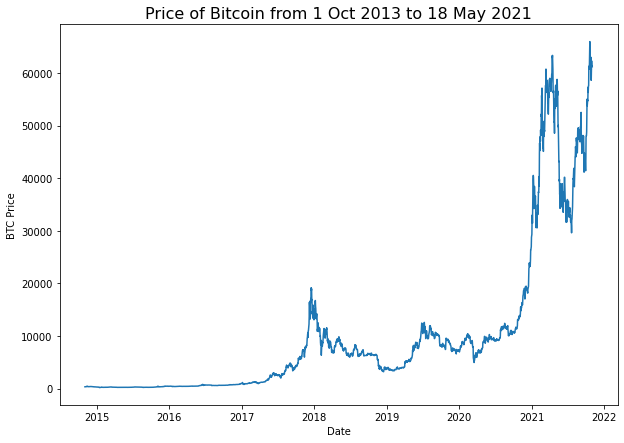

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data

In time series problems, either have univariate or multivariate data.


* Univariate time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* Multivariate time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

We're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

#### Create train & test sets for time series (the wrong way)
Turn DataFrame index and column into NumPy arrays.

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-03T00:00:00.000000000', '2014-11-04T00:00:00.000000000',
        '2014-11-05T00:00:00.000000000', '2014-11-06T00:00:00.000000000',
        '2014-11-07T00:00:00.000000000', '2014-11-08T00:00:00.000000000',
        '2014-11-09T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
        '2014-11-11T00:00:00.000000000', '2014-11-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666]))

In [ ]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2044,), (512,), (2044,), (512,))

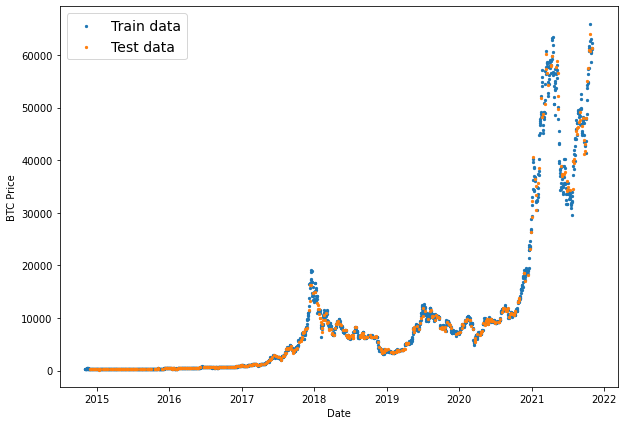

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

The seen data (training set) is Prices of Bitcoin in the past.

And unseen data (test set) is Prices of Bitcoin in the future.

Does the plot above reflect this?

No.

Test data is scattered throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

#### Create train & test sets for time series (the right way)
engineer the test set to be in the future with respect to the training set.

To do this, create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2044, 512, 2044, 512)

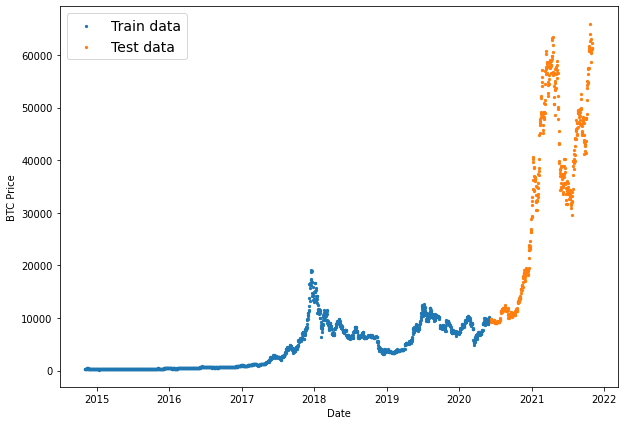

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

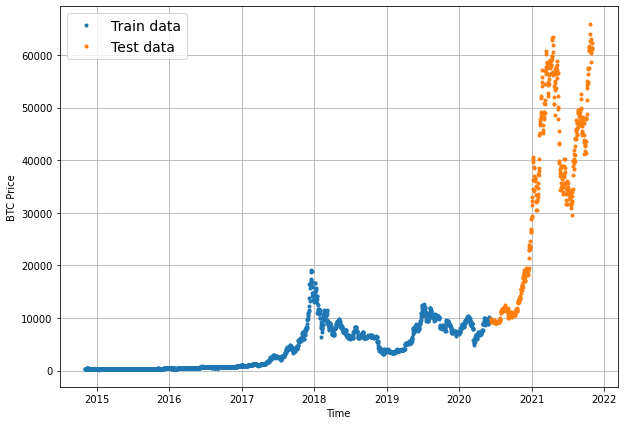

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

* horizon = number of timesteps to predict into future
* window = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

0. Naïve model (baseline)
1. Dense model, horizon = 1, window =	7	
2.	Same as model 1,	horizon = 1, window =	30
3.	Same as 1, horizon = 7, window =	30
4.	Conv1D, horizon =	1, window =	7	
5.	LSTM, horizon = 1, window =	7	
6.	Same as 1 (but with multivariate data), horizon =	1, window =	7, extra data =	Block reward size
7.	N-BEATs Algorithm, horizon =	1, window =	7
8.	Ensemble (multiple models optimized on different loss functions), horizon =	1, window =	7
9.	Future prediction model (model to predict future values), horizon =	1, window =	7
10.	Same as 1 (but with turkey 🦃 data introduced), horizon =	1, window =	7

### Model 0: Naive Forecast (baseline)
Requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with any kind of model is quite hard.

> **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game, you know the buy in and you know how much the winner can get). Time series forecasting in open systems is generally quite poor.

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([9791.92789977, 9786.14202048, 9874.96704752, 9260.83264099,
        9464.22809682, 9458.6597544 , 9351.95372801, 9441.76899555,
        9510.66063729, 9457.62707441]),
 array([60689.23826486, 61124.34712562, 60936.15085142, 63004.38111467,
        60399.73493255, 58602.20253518, 60619.26694419, 62302.70509175,
        61342.60155131, 61374.27837334]))

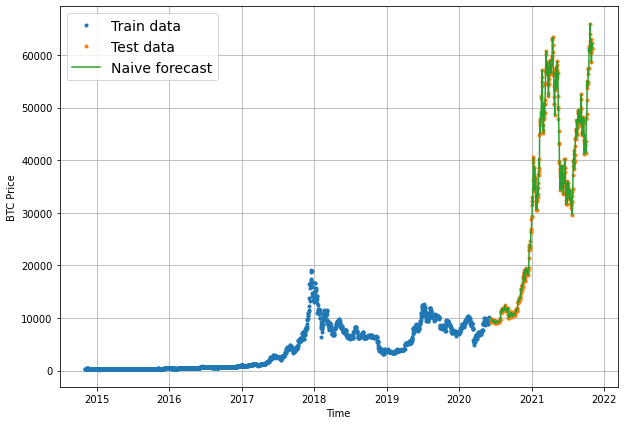

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

zoom in to take a better look

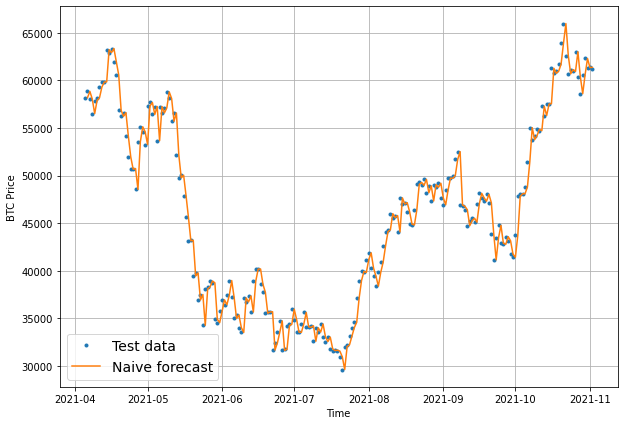

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

we're not really building a model which is off centering or shifting the y_test values, so the actual price of Bitcoin values by one index.

And so you'll notice that the new forecast, the orange line here is leading the blue line, which is the actual data.

And so why?

Because if we imagine what's the new forecast doing?

Well, it's predicting the next time step's price as been the previous time steps price. 

### Evaluating a time series model
The main thing we will be evaluating is: **how do our model's predictions (y_pred) compare against the actual values (y_true or ground truth values)?**

`Scale-dependent errors`

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

* MAE (mean absolute error) - Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median.
* RMSE (root mean square error) - Forecasts which minimise the RMSE lead to forecasts of the mean.

`Percentage errors`

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

* MAPE (mean absolute percentage error) -	Most commonly used percentage error. May explode (not work) if y=0.
* sMAPE (symmetric mean absolute percentage error) 

`Scaled errors`

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

* MASE (mean absolute scaled error) -	MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get `<1 MASE`.

For all of these metrics **lower the better** for example, an MAE of 0 is better than an MAE of 100. 

In [ ]:
import tensorflow as tf

Since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from sktime's (Scikit-Learn for time series) MeanAbsoluteScaledError class which calculates the MASE.

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's mae_loss(). In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9980551006000266

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is **~$872** different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

32739.151896736614

Okay, looking at these two values is starting to give us an idea of how our model is performing:

* The average price of Bitcoin in the test dataset is: $29,991 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $872

Is this enough to say it's a good model?

Prefer a model which was closer to the mark.

There are many other kinds of models you may want to look into for building baselines/performing forecasts.

Model/Library Name	Resource
* Moving average
* ARIMA (Autoregression Integrated Moving Average)	
* sktime (Scikit-Learn for time series)	
* TensorFlow Decision Forests (random forest, gradient boosting trees)	
* Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	
* LinkedIn Greykite (flexible, intuitive and fast forecasts)

## Format Data Part 2: Windowing dataset

Why do we window?

>Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)

`[0, 1, 2, 3, 4, 5, 6] -> [7]`

`[1, 2, 3, 4, 5, 6, 7] -> [8]`

`[2, 3, 4, 5, 6, 7, 8] -> [9]`

Or for the price of Bitcoin, it'd look like:

Window for one week with the target of predicting the next day (Bitcoin prices)

`[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]`

`[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]`

`[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]`

Build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [ ]:
# What we want our function to do :
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065] to predict this: 358.50166


In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Let's write a function which:

* Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
* Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]
```
* Uses the 2D array of multiple window steps to index on a target series
* Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2549, 2549)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [331.60083 324.71833 332.45666 336.585   346.775   344.81166 343.065  ] -> Label: [358.50166]
Window: [324.71833 332.45666 336.585   346.775   344.81166 343.065   358.50166] -> Label: [368.07666]
Window: [332.45666 336.585   346.775   344.81166 343.065   358.50166 368.07666] -> Label: [376.99666]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [61124.34712562 60936.15085142 63004.38111467 60399.73493255
 58602.20253518 60619.26694419 62302.70509175] -> Label: [61342.60155131]
Window: [60936.15085142 63004.38111467 60399.73493255 58602.20253518
 60619.26694419 62302.70509175 61342.60155131] -> Label: [61374.27837334]
Window: [63004.38111467 60399.73493255 58602.20253518 60619.26694419
 62302.70509175 61342.60155131 61374.27837334] -> Label: [61200.22575181]


**Note:** You can find a function which achieves similar results to the ones we implemented above at tf.keras.preprocessing.timeseries_dataset_from_array(). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets
We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [ ]:
full_windows[:5], full_labels[:5]

(array([[331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666],
        [346.775  , 344.81166, 343.065  , 358.50166, 368.07666, 376.99666,
         442.10666]]), array([[358.50166],
        [368.07666],
        [376.99666],
        [442.10666],
        [389.00333]]))

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2039, 510, 2039, 510)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666],
        [346.775  , 344.81166, 343.065  , 358.50166, 368.07666, 376.99666,
         442.10666]]), array([[358.50166],
        [368.07666],
        [376.99666],
        [442.10666],
        [389.00333]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
len(np.squeeze(train_labels[:-HORIZON-1])), len(y_train[WINDOW_SIZE:])

(2037, 2037)

## Make a modelling checkpoint
Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing i.e. in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if model_1 performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a ModelCheckpoint callback.

The ModelCheckpoint callback will monitor our model's performance during training and save the best model to file by setting save_best_only=True.

That way when evaluating our model we could restore its best performing configuration from file.

**Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the ModelCheckpoint callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a ModelCheckpoint callback which saves a model to specified filename.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: Dense model (window = 7, horizon = 1)

* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

Why these values?

experimentation.

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast might as well train for more.

**Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called hyperparameters. And experimenting to find the best values for hyperparameters is called hyperparameter tuning. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as parameters.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/16 [==============================] - 2s 58ms/step - loss: 1048.4646 - mae: 1048.4646 - val_loss: 4688.4927 - val_mae: 4688.4927
Epoch 2/100
16/16 [==============================] - 1s 39ms/step - loss: 395.1161 - mae: 395.1161 - val_loss: 2311.5254 - val_mae: 2311.5254
Epoch 3/100
16/16 [==============================] - 1s 37ms/step - loss: 244.4086 - mae: 244.4086 - val_loss: 1750.4620 - val_mae: 1750.4620
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 228.1191 - mae: 228.1191 - val_loss: 1601.5883 - val_mae: 1601.5883
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 220.6725 - mae: 220.6725 - val_loss: 1604.5157 - val_mae: 1604.5157
Epoch 6/100
16/16 [==============================] - 1s 37ms/step - loss: 215.2858 - mae: 215.2858 - val_loss: 1557.9248 - val_mae: 1557.9248
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 212.8782 - mae: 212.8782 - val_loss: 1581.2148 - val_mae: 1581.2148
Epoch 

In [ ]:
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 1017.3787 - mae: 1017.3787


[1017.3787231445312, 1017.3787231445312]

You'll notice the model achieves the same val_loss (in this case, this is MAE) as the last epoch.

But if we load in the version of model_1 which was saved to file using the ModelCheckpoint callback, we should see an improvement in results.

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 951.0488 - mae: 951.0488


[951.0487670898438, 951.0487670898438]

## Making forecasts with a model (on the test dataset)

* Takes in a trained model (just like model_1)
* Takes in some input data (just like the data the model was trained on)
* Passes the input data to the model's predict() method
* Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(510, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9797.628, 9870.405, 9390.796, 9410.496, 9456.88 , 9403.062,
        9403.125, 9515.149, 9487.272, 9414.198], dtype=float32)>)

> **Note:** With these outputs, our model isn't forecasting yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

we've got some prediction values, let's use the evaluate_preds() we created before to compare them to the ground truth.

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), 
                                 y_pred=model_1_preds)

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

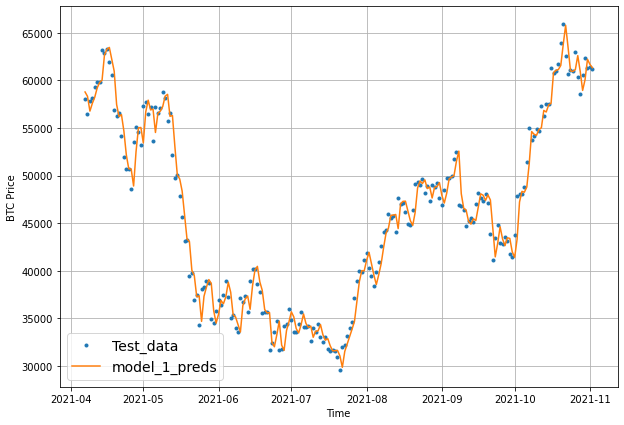

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

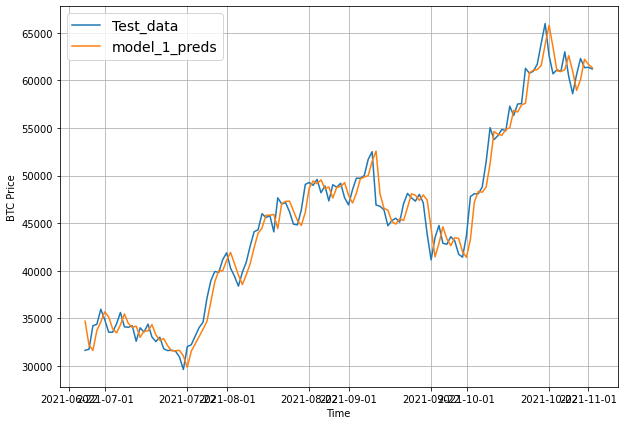

In [ ]:
offset = 380
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

they're on the test dataset. So they're not actual forecasts.
### Model 2: Dense (window = 30, horizon = 1)
A naïve model is currently beating our handcrafted deep learning model.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

> **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are hyperparameters. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [ ]:
HORIZON = 1  # predict one step at a time
WINDOW_SIZE = 30  # use 30 timesteps in the past

In [ ]:
# MAke windowed data with appropriate horizon and window_size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2526, 2526)

In [ ]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2020, 506, 2020, 506)

Now let's construct model_2, a model with the same architecture as model_1 as well as the same training routine.

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)  # need to predict horizon number of steps into the future
], name="model_2_dense")

# Compile the model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 1035.4393


1035.4393310546875

In [ ]:
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 1012.7645


1012.7645263671875

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1012.7647,
 'mape': 2.819072,
 'mase': 1.0693297,
 'mse': 2367582.0,
 'rmse': 1538.695}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

It looks like model_2 performs worse than the naïve model as well as model_1!

Does this mean a smaller window size is better? 

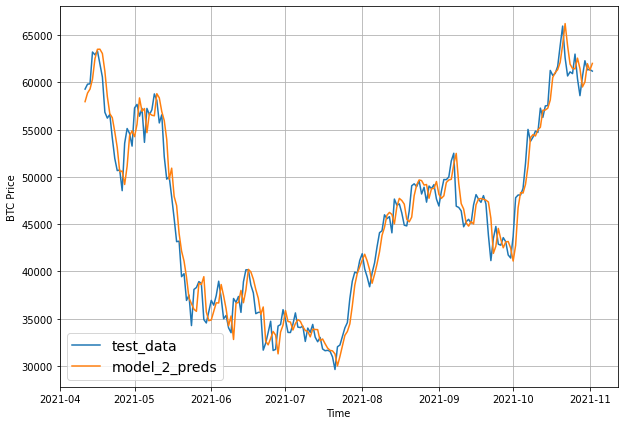

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)
Predict 7 days ahead given the previous 30 days.

First, we'll update the HORIZON and WINDOW_SIZE variables and create windowed data.

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2520, 2520)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2016, 504, 2016, 504)

In [ ]:
tf.random.set_seed(42)

# Create model(same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"), 
                               layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 2108.1257


2108.125732421875

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 2079.7368


2079.73681640625

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the make_preds() function and evaluate them using the evaluate_preds() function.

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[ 9698.585 ,  9742.293 ,  9782.5625,  9823.526 , 10072.65  ,
         9914.1875,  9784.209 ],
       [ 9730.974 ,  9866.76  ,  9916.414 ,  9908.035 ,  9991.773 ,
         9985.657 ,  9981.133 ],
       [ 9259.4   ,  9470.29  ,  9565.38  ,  9546.027 ,  9502.842 ,
         9512.2   ,  9688.682 ],
       [ 9378.138 ,  9482.561 ,  9631.798 ,  9276.565 ,  9569.34  ,
         9622.351 ,  9592.902 ],
       [ 9318.19  ,  9212.683 ,  9515.007 ,  9505.825 ,  9532.692 ,
         9496.767 ,  9427.208 ]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  401.10086 ,   490.71637 ,   126.65332 ,   183.4022  ,
          105.79716 ,   148.94978 ,   154.9739  ,   168.08789 ,
          108.39872 ,   138.87053 ,   129.33315 ,   248.55496 ,
          263.4555  ,   239.96387 ,   507.89453 ,   256.27582 ,
          226.94225 ,    52.37486 ,   137.18625 ,    99.720985,
          115.16504 ,   134.24428 ,    80.34612 ,   118.79213 ,
          186.89578 ,   151.90248 ,   239.75418 ,   114.66532 ,
           97.94545 ,   118.60519 ,    74.79925 ,   113.47517 ,
           92.84668 ,    75.29199 ,   107.205215,   113.56864 ,
          105.52818 ,   180.26758 ,   239.62723 ,   305.68512 ,
          359.53793 ,   680.7027  ,   772.55426 ,   913.4526  ,
          977.60004 ,  1208.5624  ,  1439.4983  ,  1385.2471  ,
          666.2369  ,   345.11816 ,   211.98521 ,   246.11678 ,
          291.7772  ,   258.41406 ,   128.37416 ,   184.28069 ,
          291.53293 ,   162.31975 ,   170.86063 ,   192.76535 ,
          205.5127  ,   199.44225

## Make our evaluation function work for larger horizons
You'll notice the outputs for model_3_results are multi-dimensional.

This is because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this, let's adjust our evaluate_preds() function to work with multiple shapes of data.

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      #"rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 2079.7368, 'mape': 5.748277, 'mase': 2.19685, 'mse': 10049660.0}

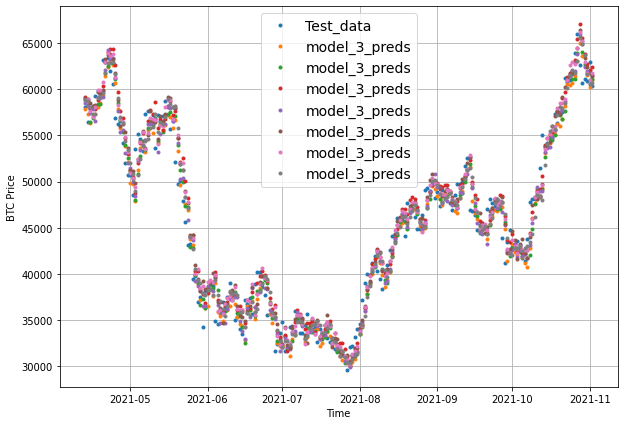

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

**Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

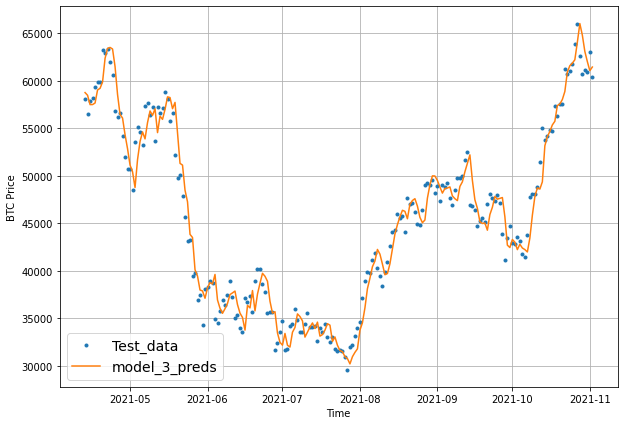

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

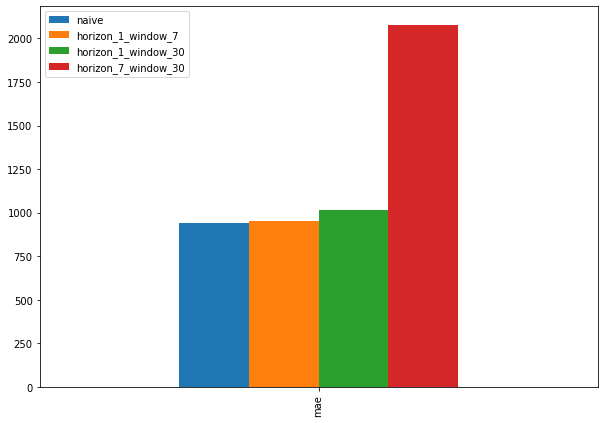

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use HORIZON=1 and WINDOW_SIZE=7 for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

**Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.


### Model 4: Conv1D
Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

In [ ]:

HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2549, 2549)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2039, 510, 2039, 510)

Data windowed!

Now, since we're going to be using Conv1D layers, we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case, the batch_size (by default this is 32 but we can change it) is handled for us but the other values will be:

* timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin
* input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our train_windows or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[331.60083]
 [324.71832]
 [332.45667]
 [336.585  ]
 [346.775  ]
 [344.81165]
 [343.065  ]]


**Note:** If you run the model below without the Lambda layer, you'll get an input shape error.

In [ ]:
tf.random.set_seed(42)

# Create model 
model_4 = tf.keras.Sequential([
                               # Create a Lambda layer to reshape inputs without this layer the model will error
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D layer 
                               layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
], name="model_4_Conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
INFO:tensorflow:Assets wr

In [ ]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in the best perfroming Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels) 

16/16 [==============================] - 0s 2ms/step - loss: 949.9840


949.9840087890625

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9810.999, 9879.308, 9404.44 , 9428.998, 9467.38 , 9386.292,
       9438.14 , 9511.446, 9493.421, 9428.847], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 949.984, 'mape': 2.6497743, 'mase': 1.0090259, 'mse': 2142681.0}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

### Model 5: RNN (LSTM)
use a recurrent neural network to model our sequential time series data.

The `tf.keras.layers.LSTM()` layer takes a tensor with `[batch, timesteps, feature]` dimensions.

To fix this, just like we did with the Conv1D model, we can use a tf.keras.layers.Lambda() layer to adjust the shape of our input tensors to the LSTM layer.

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 1004.0660


1004.0659790039062

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9814.169, 9887.467, 9527.777, 9446.325, 9467.462, 9405.948,
       9393.644, 9529.715, 9511.382, 9454.471], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1004.0658, 'mape': 2.8127522, 'mase': 1.066469, 'mse': 2328731.5}

## Make a multivariate time series
So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the Bitcoin block reward size adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

**Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [ ]:
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [ ]:
bitcoin_prices.tail()

,Price
Date,
2021-10-29,60619.266944
2021-10-30,62302.705092
2021-10-31,61342.601551
2021-11-01,61374.278373
2021-11-02,61200.225752


In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to have the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

**Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(614, 2016)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-03,331.60083,25
2014-11-04,324.71833,25
2014-11-05,332.45666,25
2014-11-06,336.58500,25
2014-11-07,346.77500,25


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-10-29,60619.266944,6.25
2021-10-30,62302.705092,6.25
2021-10-31,61342.601551,6.25
2021-11-01,61374.278373,6.25
2021-11-02,61200.225752,6.25


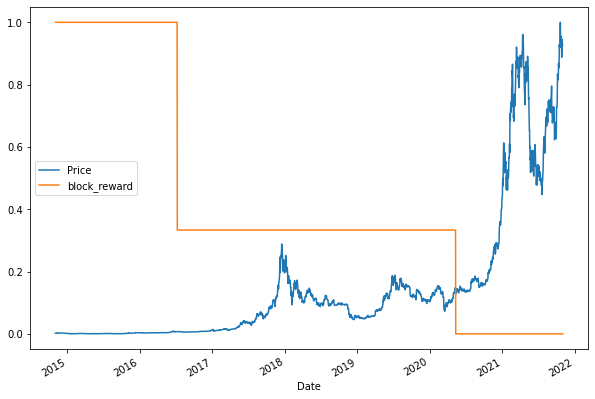

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas
Previously, we used some custom made functions to window our univariate time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the pandas.DataFrame.shift() method to create a windowed multivariate time series.

The shift() method offsets an index by a specified number of periods.

Let's see it in action.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the bitcoin historical dataset with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,,
2014-11-03,331.60083,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,NaN,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,NaN,NaN,NaN,NaN
2014-11-07,346.77500,25,336.58500,332.45666,324.71833,331.60083,NaN,NaN,NaN
2014-11-08,344.81166,25,346.77500,336.58500,332.45666,324.71833,331.60083,NaN,NaN
2014-11-09,343.06500,25,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,NaN
2014-11-10,358.50166,25,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-11,368.07666,25,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833


Now that we've got a windowed dataset, let's separate features (X) from labels (y).

Remember in our windowed dataset, we're trying to use the previous WINDOW_SIZE steps to predict HORIZON steps.

Window for a week (7) to predict a horizon of 1 (multivariate time series)
>`WINDOW_SIZE & block_reward -> HORIZON`

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the NaN values using pandas `dropna()` method, this equivalent to starting our windowing function at sample 0 (the first sample) + WINDOW_SIZE.

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991
2014-11-14,25.0,442.106659,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994


In [ ]:
# View labels
y.head()

Date
2014-11-10    358.501648
2014-11-11    368.076660
2014-11-12    376.996674
2014-11-13    442.106659
2014-11-14    389.003326
Name: Price, dtype: float32

In [ ]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2039, 2039, 510, 510)

### Model 6: Dense (multivariate time series)
To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


In [ ]:
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 942.3204


942.3204345703125

In [ ]:
# MAke predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9818.938, 9902.013, 9382.142, 9436.12 , 9503.912, 9373.655,
       9455.78 , 9553.006, 9491.742, 9438.358], dtype=float32)>

In [ ]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 942.32025, 'mape': 2.629488, 'mase': 1.0008858, 'mse': 2107783.2}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

### Model 7: Dense (multivariate time series) (adding an extra layer)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_7 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_7_dense_multivariate")

# Compile
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_7.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name)])

INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_7_dense_multivariate/assets


In [ ]:
model_7 = tf.keras.models.load_model("/content/model_experiments/model_7_dense_multivariate")
model_7.evaluate(X_test, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 938.6868


938.686767578125

In [ ]:
# Make predictions on multivariate data
model_7_preds = tf.squeeze(model_7.predict(X_test))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9780.271, 9862.176, 9312.166, 9414.001, 9464.979, 9343.387,
       9412.52 , 9501.693, 9458.727, 9391.846], dtype=float32)>

In [ ]:
# Evaluate preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 938.6867, 'mape': 2.621558, 'mase': 0.9970265, 'mse': 2099469.5}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

`model_7` performs way better than `model_1`.

### Model 8: N-BEATS algorithm
But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the `N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting)` algorithm does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the M4 competition (a forecasting competition).

focus on:

- Replicating the model architecture of the N-BEATS paper

#### Building and testing an N-BEATS block layer
Let's start by building an N-BEATS block layer

In [ ]:
# Create N-BEATS block custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,  # the constructor takes all the hyperparameters from the layer 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argumnets takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with layer activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, self.input_size], theta[:, self.horizon:]
    return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inouts to dummy NBeatsLayer layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: -0.4397902190685272
Forecast: [ 0.10944453 -0.43355346  0.9360242  -0.35703537 -0.17927602 -0.34048367
 -0.43979022]


## Preparing data for the N-BEATS algorithm using tf.data
to ensure our model training runs as fast as possible, setup our datasets using the `tf.data API`.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to loadblock

In [ ]:
# Create NBeats data inputs
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range (WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-10,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-11,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833
2014-11-12,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666
2014-11-13,442.10666,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500,336.58500
2014-11-14,389.00333,442.10666,376.99666,368.07666,358.50166,343.06500,344.81166,346.77500


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

#Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2039, 2039, 510, 510)

convert train and test sets into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:

1. Turning the arrays in tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
  - Note: from_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord format
2. Combine the labels and features tensors into a Dataset using `tf.data.Dataset.zip()`
3. Batch and prefetch the Datasets using batch() and prefetch()

- Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

In [ ]:
# Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine feature and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and preface for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-Beats paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

Notice the input shape for the features (None, 7), the None leaves space for the batch size where as the 7 represents the WINDOW_SIZE.

## Setting up Hyperparameters for N-BEATS Algorithm

create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

## Getting ready for residual connections

there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


> What is a residual connection?

A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

Subtract the backcast outputs from a previous block from the backcast inputs to the current block
Add the forecast outputs from all blocks together in a stack
> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures"

It's thought that they help avoid the problem of vanishing gradients (patterns learned by a neural network not being passed through to deeper layers).

## Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  - tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
  - tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [ ]:
%%time
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer 
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input(backwards predictions are preferred to as residual in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):  # first stack is already created in (3)

  # 5. Use the NBeats to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)  # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_8 = tf.keras.Model(inputs=stack_input,
                         outputs= forecast,
                         name="model_8_N-BEATS")

# 8. Compile with mae loss and Adam optimizer
model_8.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_8.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 43min 3s, sys: 1min, total: 44min 4s
Wall time: 31min 7s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_8.evaluate(test_dataset)

1/1 [==============================] - 0s 454ms/step - loss: 965.7009 - mae: 965.7009 - mse: 2213751.5000


[965.700927734375, 965.700927734375, 2213751.5]

In [ ]:
# Make predictions with N-BEATS model
model_8_preds = make_preds(model_8, test_dataset)
model_8_preds[:10]

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[9800.269 , 9838.284 , 9825.017 , 9856.395 , 9802.714 , 9801.184 ,
        9801.662 ],
       [9869.948 , 9890.372 , 9889.701 , 9917.025 , 9866.8545, 9871.272 ,
        9866.793 ],
       [9293.592 , 9288.536 , 9317.566 , 9316.384 , 9289.349 , 9290.683 ,
        9268.74  ],
       [9476.016 , 9424.172 , 9471.111 , 9479.568 , 9427.386 , 9483.81  ,
        9441.201 ],
       [9487.598 , 9474.109 , 9493.187 , 9493.376 , 9449.493 , 9472.739 ,
        9451.434 ],
       [9420.373 , 9420.337 , 9454.202 , 9442.905 , 9433.373 , 9430.721 ,
        9399.656 ],
       [9505.726 , 9468.351 , 9520.337 , 9529.722 , 9496.212 , 9509.416 ,
        9481.463 ],
       [9510.297 , 9499.823 , 9503.033 , 9527.807 , 9468.297 , 9486.257 ,
        9469.862 ],
       [9472.551 , 9509.607 , 9497.155 , 9528.189 , 9480.709 , 9479.223 ,
        9477.697 ],
       [9419.344 , 9438.209 , 9435.766 , 9453.352 , 9400.82  , 9408.698 ,
        9407.3125]], dtype=floa

In [ ]:
# Evaluate N-BEATS models predictions
model_8_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_8_results

{'mae': 938.6867, 'mape': 2.621558, 'mase': 0.9970265, 'mse': 2099469.5}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

## Plotting the N-BEATS architechture 

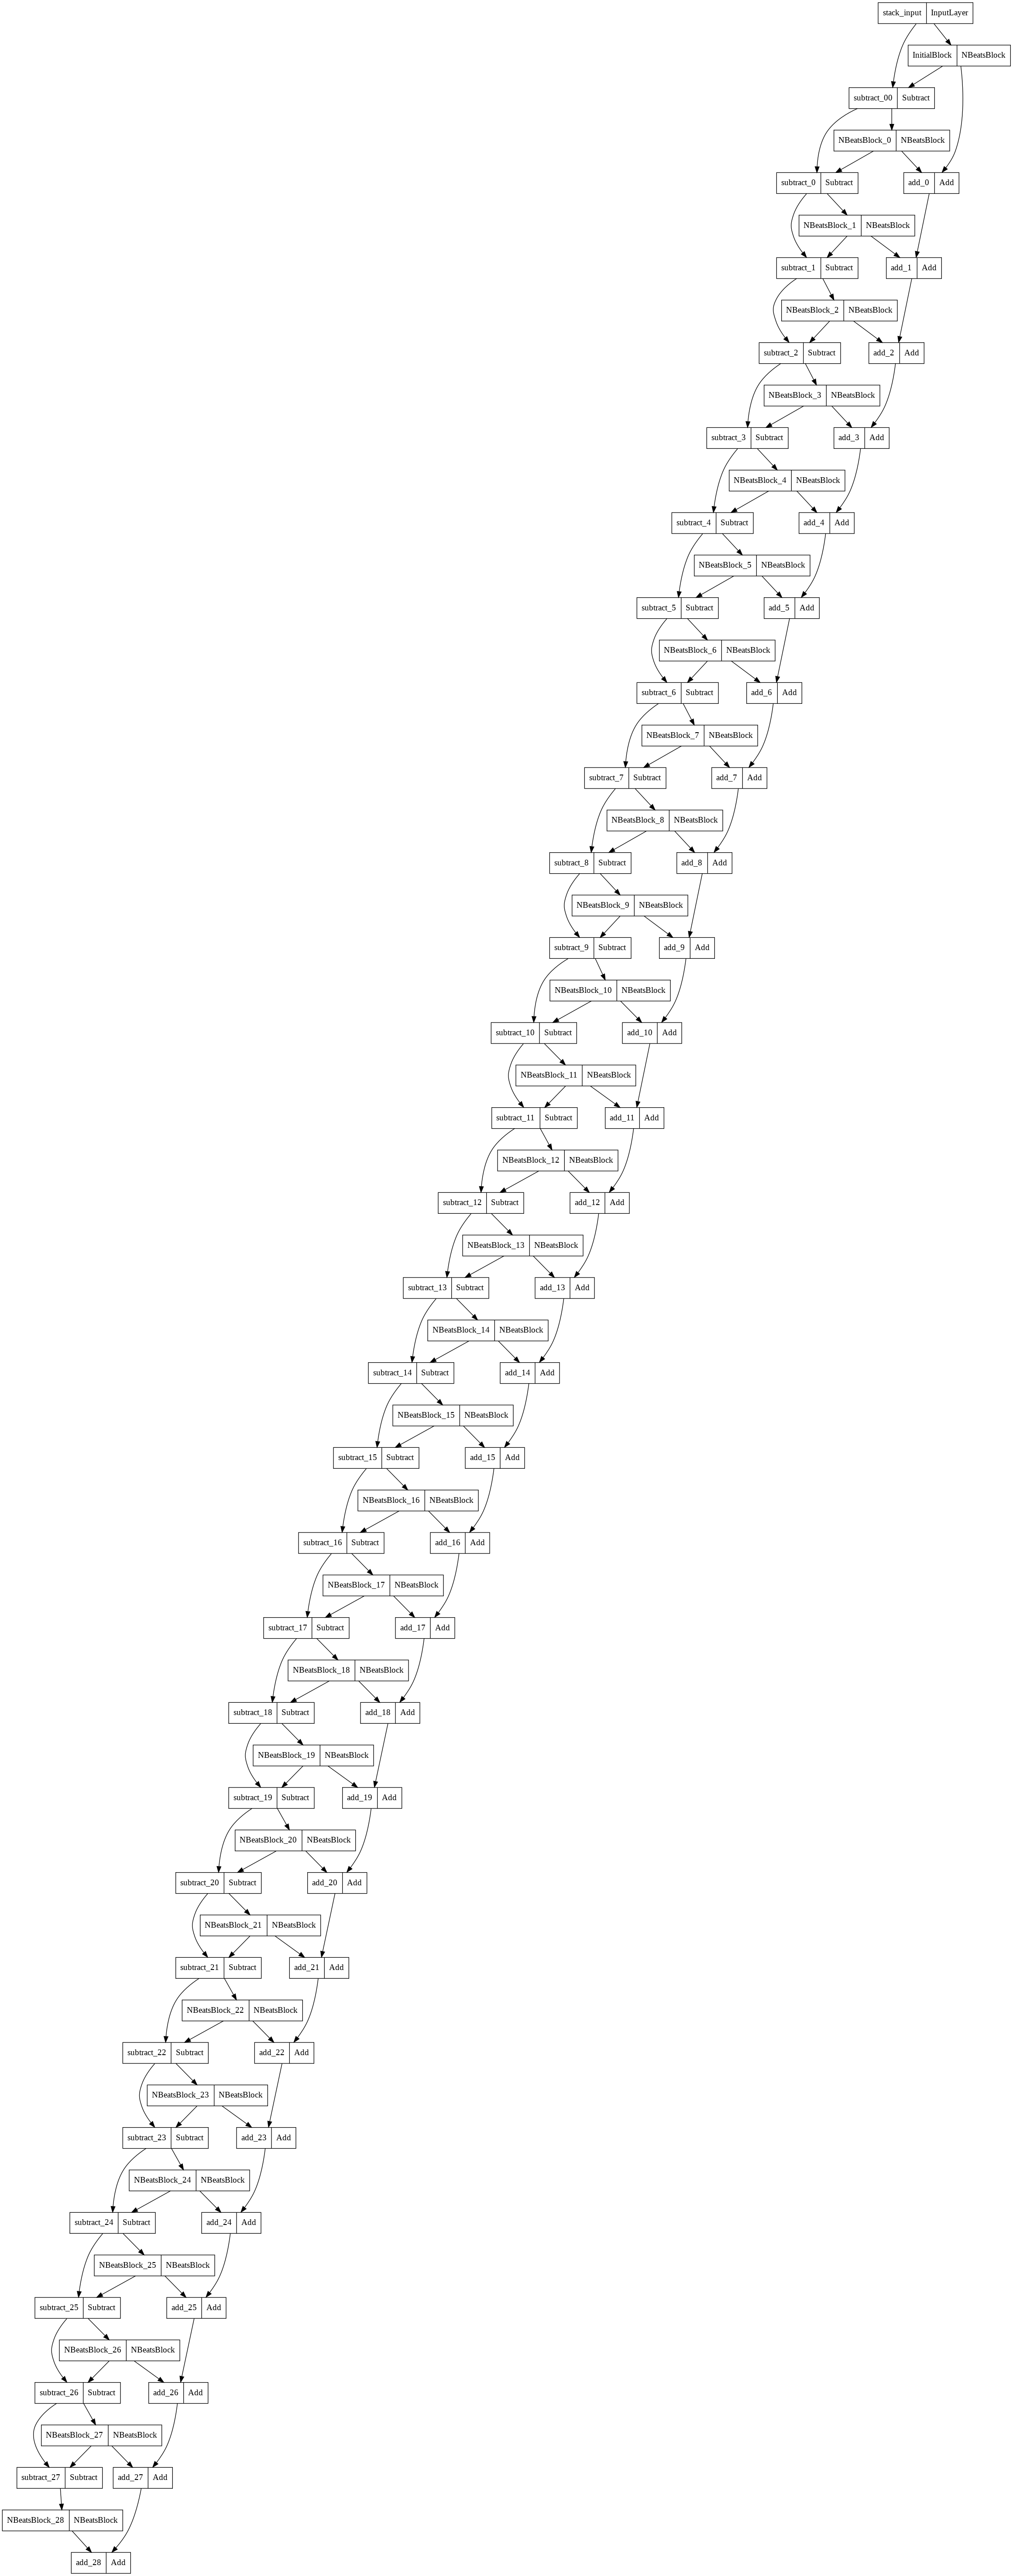

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_8)

In [ ]:
model_8.save(model_8.name)

INFO:tensorflow:Assets written to: model_8_N-BEATS/assets


INFO:tensorflow:Assets written to: model_8_N-BEATS/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Model 9: Creating an ensemble (stacking different models together)
An ensemble involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

In the N-BEATS paper, they trained an ensemble of models (180 in total, see section 3.4) to achieve the results they did using a combination of:

- Different loss functions (sMAPE, MASE and MAPE)
- Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)
The benefit of ensembling models is you get the `"decision of the crowd effect"`. Rather than relying on a single model's predictions, take the average or median of many different models.

The keyword being: different.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results.

What this means is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on.

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create our ensemble models we're going to be using a combination of:

- Different loss functions (MAE, MSE, MAPE)
- Randomly initialized models

Start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal (Gaussian) distribution using He normal initialization, this'll help estimating the prediction intervals.

### Constructing and fitting an ensemble of models(using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [ ]:
%%time
# Get list of trained ensemble model
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00294: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00643: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00743: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00405: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00505: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 00761: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00877: ReduceLR

### Making predictions with Ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 510), dtype=float32, numpy=
array([[ 9786.028,  9858.472,  9285.241, ..., 62098.83 , 61517.062,
        61378.766],
       [ 9786.511,  9883.853,  9192.567, ..., 62980.734, 61391.13 ,
        61108.06 ],
       [ 9787.579,  9865.289,  9250.695, ..., 62448.96 , 61399.402,
        61465.   ],
       ...,
       [ 9791.725,  9864.537,  9319.799, ..., 62317.312, 61658.992,
        61283.895],
       [ 9771.918,  9800.048,  9195.183, ..., 62246.125, 61665.88 ,
        60615.316],
       [ 9790.978,  9869.934,  9276.747, ..., 62151.918, 61682.98 ,
        61469.566]], dtype=float32)>

Since 15 models are trained, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, take the median.

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 941.08325, 'mape': 2.6269875, 'mase': 0.999572, 'mse': 2131563.0}

In [ ]:
model_8_results

{'mae': 938.6867, 'mape': 2.621558, 'mase': 0.9970265, 'mse': 2099469.5}

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

In [ ]:
naive_results

{'mae': 937.98645,
 'mape': 2.615954,
 'mase': 0.99805504,
 'mse': 2081908.9,
 'rmse': 1442.8822}

The ensemble model is the best performing model on the MAE metric so far.

## Plotting the prediction intervals (uncertainty estimates) of the ensemble
All of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of WINDOW_SIZE=7 values, the model will predict HORIZION=1.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD?

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a point prediction, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be outside of this range as well, but we'll get to that later).

These kind of prediction ranges are called prediction intervals or uncertainty estimates. And they're often as important as the forecast itself.

Why?

Because point predictions are almost always going to be wrong. So having a range of values can help with decision making.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (done this)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
#Find upper and lower bounds ofensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural network

  # 2. Measure the standard deviation of the predictions 
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviations by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

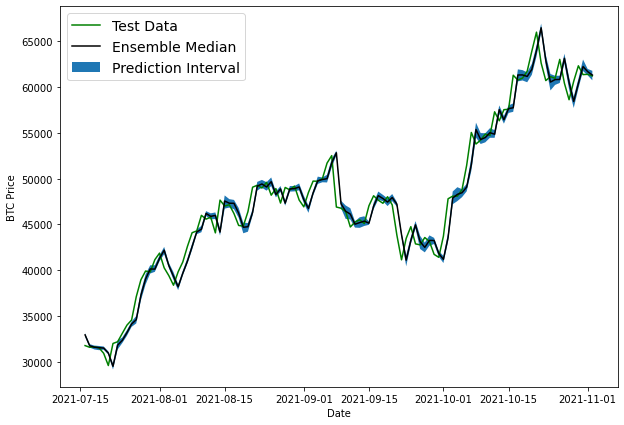

In [ ]:
# get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the predictions intervals (where the predictions fall between)
offset = 400
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14);

We've just plotted:

- The test data (the ground truth Bitcoin prices)
- The median of the ensemble predictions
-The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

## Uncertainty

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

**Aleatoric uncertainty** - 
- This type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.
- When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

**Epistemic uncertainty** - 
- This type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
- Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.


### Model 10 : Train a model on the full historical data to make predictions into future
Previously, we split data into training and test sets to evaluate how our model did on pseudo-future data (the test set).

But since the goal of a forecasting model is to predict values into the actual-future, we won't be using a test set.

**Note:** Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,,
2014-11-03,331.60083,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,NaN,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,NaN,NaN,NaN,NaN
2014-11-07,346.77500,25,336.58500,332.45666,324.71833,331.60083,NaN,NaN,NaN


In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:

- Turning X_all and y_all into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
- Combining the features and labels into a Dataset tuple using `tf.data.Dataset.zip()`
- Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively

In [ ]:
# 1. Turn X_all and y_all into tensor datasets 
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and preface for optimal performance
BATCH_SIZE = 1024 # Taken from appendix D of N_BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

Now create a model similar to `model_1` with an extra layer. Also fit the dataset for 100 epochs 

In [ ]:
tf.random.set_seed(42)

# Create model
model_9 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
])

# Compile 
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

## Make Predictions into the future 
Start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into future

In [ ]:
# How many timesteps into the future ?
INTO_FUTURE = 14

Create a function which returns `INTO_FUTURE` forecasted values using a trained model

To do so build the following steps :
1. Function which takes an input:
  - a list of values (a bitcoin historical data)
  - a trained model (such as model_9)
  - a window into the future to predict (our future variable)
  - the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data as it was trained on 
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last WINDOW_SIZE values from the input values (predictions will start from the last WINDOW_SIZE values of the training data)
3. Loop INTO_FUTURE times making a prediction on WINDOW_SIZE dataset which update to remove the first value and append the last prediction 
  - Eventually future predictions will be made using the models own previous predictions as input

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [60399.73493255 58602.20253518 60619.26694419 62302.70509175
 61342.60155131 61374.27837334 61200.22575181] -> Prediction: 60234.34375

Predicting on: 
 [58602.20253518 60619.26694419 62302.70509175 61342.60155131
 61374.27837334 61200.22575181 60234.34375   ] -> Prediction: 60221.48046875

Predicting on: 
 [60619.26694419 62302.70509175 61342.60155131 61374.27837334
 61200.22575181 60234.34375    60221.48046875] -> Prediction: 61915.61328125

Predicting on: 
 [62302.70509175 61342.60155131 61374.27837334 61200.22575181
 60234.34375    60221.48046875 61915.61328125] -> Prediction: 62255.99609375

Predicting on: 
 [61342.60155131 61374.27837334 61200.22575181 60234.34375
 60221.48046875 61915.61328125 62255.99609375] -> Prediction: 61529.42578125

Predicting on: 
 [61374.27837334 61200.22575181 60234.34375    60221.48046875
 61915.61328125 62255.99609375 61529.42578125] -> Prediction: 61419.65234375

Predicting on: 
 [61200.22575181 60234.34375    60221.48046875 61915.6

In [ ]:
future_forecast[:10]

[60234.344,
 60221.48,
 61915.613,
 62255.996,
 61529.426,
 61419.652,
 61206.895,
 60903.562,
 61551.797,
 62457.336]

## Plot future forecast
Plot our model's future forecasts against the historical data of Bitcoin, theres a need of series of future dates (future dates from the final date of where our dataset ends).

Create a function to return a date range from some specified start date to a specified number of days into the future (INTO_FUTURE).

To do so, use a combination of NumPy's datetime64 datatype (Bitcoin dates are already in this datatype) as well as NumPy's timedelta64 method which helps to create date ranges.

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be last dates of our dataset

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-11-02 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06',
       '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10',
       '2021-11-11', '2021-11-12', '2021-11-13', '2021-11-14',
       '2021-11-15', '2021-11-16'], dtype='datetime64[D]')

got a list of dates we can use to visualize our future Bitcoin predictions.

In [ ]:
# Insert last timestep/final price so that graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
        '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
        '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13',
        '2021-11-14', '2021-11-15', '2021-11-16'], dtype='datetime64[D]'),
 array([61200.227, 60234.344, 60221.48 , 61915.613, 62255.996, 61529.426,
        61419.652, 61206.895, 60903.562, 61551.797, 62457.336, 62207.152,
        61702.676, 61665.613, 61631.086], dtype=float32))

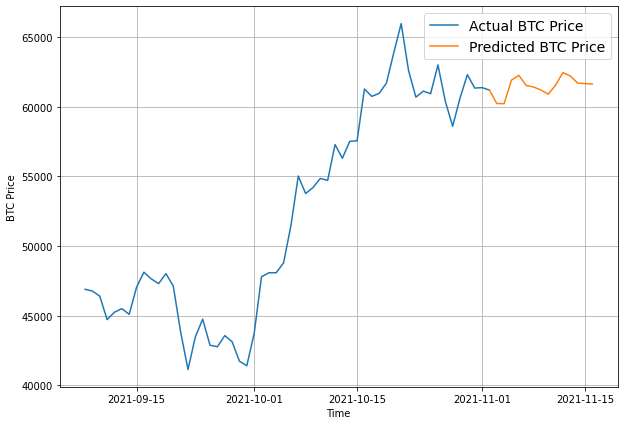

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

The pattern is due to model overfitting the training data and not generalizing well for future data. Also the further you predict into the future the higher your chances for error 
### Model 11: where Price of BTC falls 100x in a day
when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

You could have the historical data of Bitcoin for its existence and build a model which predicts it perfectly. But one for unknown and unpredictable reason the price of Bitcoin plummets 100x in a single day.

**Note:** A very unlikely and unpredictable event such as the price of Bitcoin falling 100x in a single day (note: the adjective **"unlikely"** is based on the historical price changes of Bitcoin) is also referred to a **`Black Swan event`**. A Black Swan event is an unknown event, you have no way of predicting whether or not it will happen but these kind of events often have a large impact.


In [ ]:
btc_price_black_swan = btc_price.copy()
btc_price_black_swan[-1] = btc_price_black_swan[-1] / 100

In [ ]:
# Manufacture an extra price at the end 
btc_price_black_swan[-10:]

[61124.3471256221,
 60936.1508514192,
 63004.3811146675,
 60399.73493255,
 58602.202535179,
 60619.2669441898,
 62302.7050917453,
 61342.6015513088,
 61374.2783733446,
 612.002257518147]

Notice that the last value is 100x lower than what it actually was (remember it is not a real datapoint it is used just to illustrate the black swan effect)


In [ ]:
# Get the timesteps for turkey problems
btc_timesteps_black_swan= np.array(bitcoin_prices.index)
btc_timesteps_black_swan[-10:]

array(['2021-10-24T00:00:00.000000000', '2021-10-25T00:00:00.000000000',
       '2021-10-26T00:00:00.000000000', '2021-10-27T00:00:00.000000000',
       '2021-10-28T00:00:00.000000000', '2021-10-29T00:00:00.000000000',
       '2021-10-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-11-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

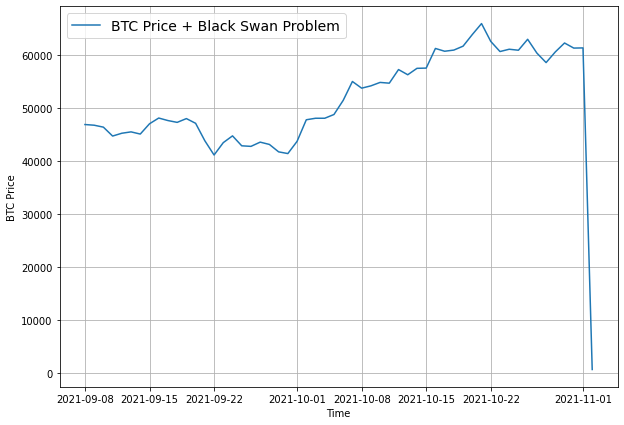

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_black_swan,
                 values=btc_price_black_swan,
                 format='-',
                 label="BTC Price + Black Swan Problem",
                 start=2500)

In [ ]:
# Create train and test set for Black Swan dataset
full_windows, full_labels = make_windows(np.array(btc_price_black_swan), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2039, 510, 2039, 510)

## Building a Black Swan model (clone of model_1 i.e. same architechture but different data)

In [ ]:
model_11 = tf.keras.models.clone_model(model_1)
model_11._name = "model_11_black_swan"
model_11.compile(loss="mae", 
                     optimizer=tf.keras.optimizers.Adam())

model_11.fit(X_train, y_train,
             epochs=100,
             verbose=0,
             validation_data=(X_test, y_test),
             callbacks=[create_model_checkpoint(model_11.name)])

INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


INFO:tensorflow:Assets written to: model_experiments/model_11_black_swan/assets


In [ ]:
#Evaluate the model
model_11.evaluate(X_test, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 1057.7910


1057.791015625

In [ ]:
# Load best model and evaluate on test data
model_11 = tf.keras.models.load_model("/content/model_experiments/model_11_black_swan")
model_11.evaluate(X_test, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 1055.1744


1055.1744384765625

In [ ]:
# Make predictions 
model_11_preds = make_preds(model_11, X_test)
model_11_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9799.215 , 9867.306 , 9319.869 , 9423.016 , 9454.79  , 9359.78  ,
       9448.21  , 9490.45  , 9476.1875, 9405.112 ], dtype=float32)>

In [ ]:
# Evaluate turkey preds
model_11_results = evaluate_preds(y_true=y_test,
                                y_pred=model_11_preds)
model_11_results

{'mae': 20436.28, 'mape': 108.20771, 'mase': 19.270056, 'mse': 641783550.0}

And with just one value change, error metrics go through the roof.

In [ ]:
model_1_results

{'mae': 951.04865,
 'mape': 2.6500783,
 'mase': 1.0101568,
 'mse': 2150623.2,
 'rmse': 1466.5004}

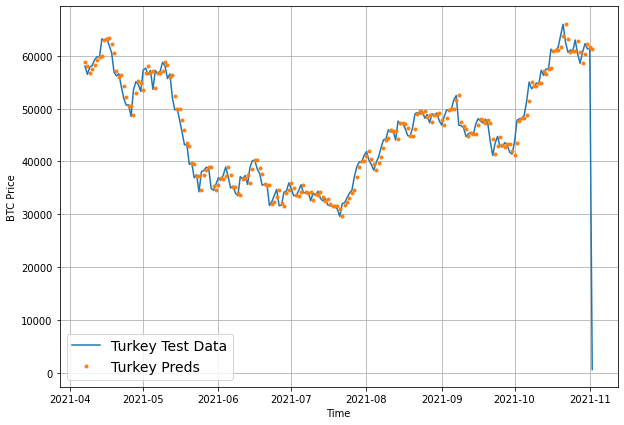

In [ ]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(timesteps=btc_timesteps_black_swan[-len(X_test):], 
                 values=btc_price_black_swan[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_black_swan[-len(X_test):],
                 values=model_11_preds, 
                 label="Turkey Preds", 
                 start=offset);

Why does the model fail to capture the turkey problem data point?

A model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

However, as we've seen, despite their unlikeliness, these events can have huuuuuuuuge impacts to the performance of our models.

## Compare models

In [ ]:
# Compare different models results (window = w, horizon = h)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_multivariate_extra_layer": model_7_results,
                              "model_8_NBEATs": model_8_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": model_11_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,937.986450,2.081909e+06,1442.882202,2.615954,0.998055
model_1_dense_w7_h1,951.048645,2.150623e+06,1466.500366,2.650078,1.010157
model_2_dense_w30_h1,1012.764709,2.367582e+06,1538.694946,2.819072,1.069330
model_3_dense_w30_h7,2079.736816,1.004966e+07,NaN,5.748277,2.196850
model_4_CONV1D,949.984009,2.142681e+06,NaN,2.649774,1.009026
model_5_LSTM,1004.065796,2.328732e+06,NaN,2.812752,1.066469
model_6_multivariate,942.320251,2.107783e+06,NaN,2.629488,1.000886
model_7_multivariate_extra_layer,938.686707,2.099470e+06,NaN,2.621558,0.997027
model_8_NBEATs,938.686707,2.099470e+06,NaN,2.621558,0.997027
model_9_ensemble,941.083252,2.131563e+06,NaN,2.626987,0.999572


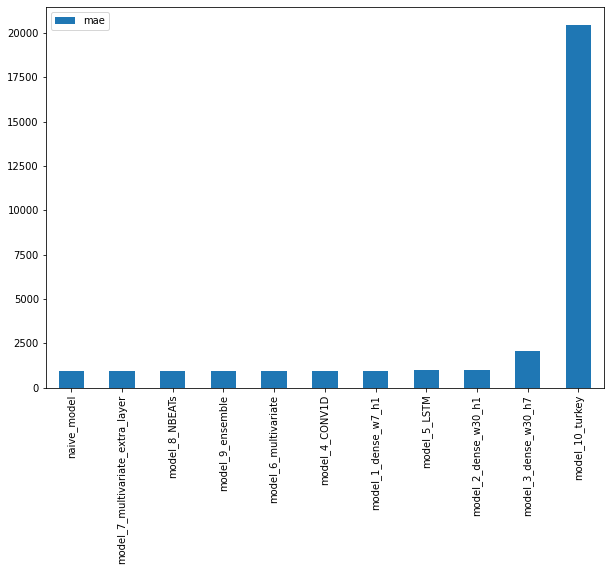

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

# Exercises
1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

In [ ]:
# Instantiating the sklearn MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [ ]:
# Create function to view NumPy arrays as windows 

def get_labelled_windows(x , horizon):
  return x[:, :-horizon] ,x[: , -horizon:]


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applies the standard scaler
  """
  scaler.fit(np.expand_dims(x , axis =1))
  scaled_x = scaler.transform(np.expand_dims(x , axis = 1))
  scaled_x = np.squeeze(scaled_x)
  
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the splits 
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

In [ ]:
# Model 1 (Horizon = 1 , Window_size = 7)
HORIZON = 1 
WINDOW_SIZE = 7 

full_windows , full_labels = make_windows_scaled(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
full_windows.shape , full_labels.shape

((2549, 7), (2549, 1))

In [ ]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [0.00210171 0.00199708 0.00211472 0.00217748 0.0023324  0.00230255
 0.002276  ] --> Label [0.00251067]
Window: [0.00199708 0.00211472 0.00217748 0.0023324  0.00230255 0.002276
 0.00251067] --> Label [0.00265623]
Window: [0.00211472 0.00217748 0.0023324  0.00230255 0.002276   0.00251067
 0.00265623] --> Label [0.00279184]


In [ ]:
# Making train and test splits 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2039, 510, 2039, 510)

In [ ]:
tf.random.set_seed(42)

# Construct the model
model_12 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation='linear')
])

# Compile the model
model_12.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae"])

# Fit the model
model_12.fit(x = train_windows,
             y = train_labels,
             epochs=100,
             batch_size = 128,
             verbose = 0,
             validation_data = (test_windows, test_labels))

In [ ]:
model_12.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 0.0165 - mae: 0.0165


[0.01654614694416523, 0.01654614694416523]

In [ ]:
# Making Prediction
model_12_preds = tf.squeeze(model_1.predict(test_windows))

Now doing the same for the Multivariate data especially for the Model 6

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991
2014-11-14,25.0,442.106659,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994


In [ ]:
# Scaling the X data 
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y , axis = 1))
y_scaled = np.squeeze(y_scaled)

In [ ]:
# Make train and test set splits of the scaled data 
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2039, 2039, 510, 510)

In [ ]:
# Building a Multivariate time series model and fitting it
tf.random.set_seed(42)

model_13 = tf.keras.Sequential([
  layers.Dense(128 , activation= 'relu'), 
  layers.Dense(HORIZON)
])

model_13.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam())

model_13.fit(X_train , y_train , 
          epochs = 100 ,
          verbose = 0 , batch_size = 128, 
          validation_data = (X_test , y_test))

In [ ]:
# Evaluate
model_13.evaluate(X_test, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.1104


0.11035469174385071

### For most of our models we used WINDOW_SIZE=7, but is there a better window size?
- Setup a series of experiments to find whether or not there’s a better window size.
- For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [ ]:
# 10 different model with window size ranging from (2 -12) and store the results
model_result_list = []

from tqdm import tqdm
for size in tqdm(range(2, 12)):
  HORIZON = 1
  WINDOW_SIZE = size

  # Making window and labels
  full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

  # Splitting the data into train and test sets
  train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

  # Building a model
  input = layers.Input(shape=(WINDOW_SIZE, ), name='Input_layer')
  x = layers.Dense(128, activation="relu")(input)
  output = layers.Dense(HORIZON, activation="linear")(x)

  # Packing into a model
  model_14 = tf.keras.Model(input, output, name=f'model_windowed_{size}')

  #Compiling and fitting the model
  model_14.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model_14.fit(train_windows , train_labels , 
            epochs = 100 , verbose = 0 , 
            batch_size = 128 , 
            validation_data = (test_windows , test_labels))
  

  # Making predictions 
  preds_ = model_14.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  model_14_results = evaluate_preds(tf.squeeze(test_labels) , y_preds)
  model_result_list.append(model_14_results)

100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


In [ ]:
model_result_list

[{'mae': 938.5804, 'mape': 2.6180289, 'mase': 0.998687, 'mse': 2099993.0},
 {'mae': 943.74677, 'mape': 2.6346824, 'mase': 1.0041842, 'mse': 2112201.8},
 {'mae': 936.9775, 'mape': 2.6178348, 'mase': 0.9969815, 'mse': 2093103.4},
 {'mae': 943.1081, 'mape': 2.62903, 'mase': 1.0035048, 'mse': 2115528.8},
 {'mae': 946.2817, 'mape': 2.6366837, 'mase': 1.0050935, 'mse': 2135935.2},
 {'mae': 1012.5395, 'mape': 2.8649411, 'mase': 1.0754693, 'mse': 2296061.0},
 {'mae': 946.59705, 'mape': 2.631841, 'mase': 1.0054284, 'mse': 2128820.2},
 {'mae': 973.89124, 'mape': 2.7132225, 'mase': 1.0344191, 'mse': 2212397.0},
 {'mae': 1061.7686, 'mape': 3.0066204, 'mase': 1.1277579, 'mse': 2506311.0},
 {'mae': 1000.1099, 'mape': 2.8110592, 'mase': 1.0615406, 'mse': 2262712.0}]

### For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
- Are there any other features you think you could add?
- If so, try it out, how do these affect the model?

In [ ]:
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-03,BTC,331.600830,325.226330,333.759830,319.043500
2014-11-04,BTC,324.718330,331.600830,332.751330,323.063330
2014-11-05,BTC,332.456660,324.718330,335.811660,320.933330
2014-11-06,BTC,336.585000,332.456660,341.490000,328.561660
2014-11-07,BTC,346.775000,336.585000,351.575000,336.028330
...,...,...,...,...,...
2021-10-29,BTC,60619.266944,58476.184714,62450.034023,57965.311022
2021-10-30,BTC,62302.705092,60600.419445,62979.128248,60239.030204
2021-10-31,BTC,61342.601551,62251.243490,62356.987743,60796.371434


In [ ]:
import datetime
# Creating day of the week feature
df["day_of_week"] = df.index.dayofweek
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),day_of_week
Date,,,,,,
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350,0
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333,1
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333,2
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166,3
2014-11-07,BTC,346.77500,336.58500,351.57500,336.02833,4
2014-11-08,BTC,344.81166,346.77500,351.29500,339.86000,5
2014-11-09,BTC,343.06500,344.81166,345.62500,340.63000,6
2014-11-10,BTC,358.50166,343.06500,363.85333,342.32500,0
2014-11-11,BTC,368.07666,358.50166,374.71166,357.98000,1


In [ ]:
# Defining the hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [ ]:
# Getting three kind of data (univariate, multivariate and the day of week)

# Univariate data
full_windows , full_labels = make_windows_scaled(prices)
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Multivaritate dat 
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
X_scaled = scaler.fit_transform(X)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# Day of week 
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [ ]:
# Checking the shapes 
print(full_windows.shape , full_labels.shape)
print(X.shape , y.shape)
print(len(day_of_week))

(2549, 7) (2549, 1)
(2549, 9) (2549,)
2549


In [ ]:
# Splitting the multivariate and the day_of_week to train and test splits 
split_size = int(len(X) * 0.8)
train_block_rewards , test_block_rewards = X[:split_size] , X[split_size:]
train_days , test_days = day_of_week[:split_size] , day_of_week[split_size:]
 
len(train_block_rewards), len(train_days) , len(test_block_rewards) , len(test_days)

(2039, 2039, 510, 510)

In [ ]:
# Building a dataset
train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows, train_block_rewards, train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# The test/val split
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows,
                                                       test_block_rewards,
                                                       test_days))

test_label_tribid = tf.data.Dataset.from_tensor_slices(test_labels)

# Zipping the data and labels into one dataset
tribid_train_dataset = tf.data.Dataset.zip((train_data_tribid, train_labels_tribid))
tribid_test_dataset = tf.data.Dataset.zip((test_data_tribid, test_label_tribid))

# Applying prefetch and batching the dataset
tribid_train_dataset = tribid_train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_dataset = tribid_test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_dataset, tribid_test_dataset

(<PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>,
 <PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>)

In [191]:
# Building a Tribid model

input_windows = layers.Input(shape = (7,) , dtype=tf.float64 , name='Window Inputs')
exp_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_windows)
conv1 = layers.Conv1D(filters= 32 , kernel_size=5 , padding='causal' , activation= 'relu')(exp_layer_1)
window_model = tf.keras.Model(input_windows , conv1 , name = 'Windowed model')

input_blocks = layers.Input(shape = (9,) , dtype= tf.float32 , name ='Block rewards input')
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_blocks)
conv2 = layers.Conv1D(filters = 32 , kernel_size= 5 , activation= 'relu' , padding = 'causal')(exp_layer_2)
block_model = tf.keras.Model(input_blocks , conv2 , name = 'Block rewards model')


# Use expand dims to match the same shape output (None , 1 , 128)
# whereas without expand dims it would be (None , 128)
input_days = layers.Input(shape= (1,) , dtype = tf.int32 , name ='Days of week Input')
exp_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_days)
dense = layers.Dense(128 , activation= 'relu')(exp_layer_3)
days_model = tf.keras.Model(input_days , dense , name = 'Days Model')

# Concatenating the inputs 
concat = layers.Concatenate(name = 'combined_outputs' )([window_model.output , 
                                                           block_model.output , 
                                                           days_model.output])

# Creating the output layer 
dropout = layers.Dropout(0.4)(concat)
output_layer = layers.Dense(1 , activation = 'linear')(dropout)

# Putting everything into a model 
tribid_model = tf.keras.Model(inputs = [window_model.input , 
                                        block_model.input , 
                                        days_model.input] , 
                              outputs = output_layer)
tribid_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Window Inputs (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 Block rewards input (InputLaye  [(None, 9)]         0           []                               
 r)                                                                                               
                                                                                                  
 Days of week Input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                              

In [194]:
# Compiling and fitting the model 
tribid_model.compile(loss = 'mae' , 
                     optimizer = 'adam' , metrics = ['mae'])

# Fitting the model 
tribid_model.fit(tribid_train_dataset , 
                 epochs = 20,  
                 validation_data = tribid_test_dataset , verbose = 2)

Epoch 1/20
16/16 - 2s - loss: 153.0028 - mae: 153.0028 - val_loss: 53.7817 - val_mae: 53.7817 - 2s/epoch - 95ms/step
Epoch 2/20
16/16 - 0s - loss: 96.7140 - mae: 96.7140 - val_loss: 83.8813 - val_mae: 83.8813 - 58ms/epoch - 4ms/step
Epoch 3/20
16/16 - 0s - loss: 56.2757 - mae: 56.2757 - val_loss: 38.9281 - val_mae: 38.9281 - 67ms/epoch - 4ms/step
Epoch 4/20
16/16 - 0s - loss: 30.8417 - mae: 30.8417 - val_loss: 63.0085 - val_mae: 63.0085 - 71ms/epoch - 4ms/step
Epoch 5/20
16/16 - 0s - loss: 12.7569 - mae: 12.7569 - val_loss: 32.8492 - val_mae: 32.8492 - 59ms/epoch - 4ms/step
Epoch 6/20
16/16 - 0s - loss: 4.0087 - mae: 4.0087 - val_loss: 8.6098 - val_mae: 8.6098 - 69ms/epoch - 4ms/step
Epoch 7/20
16/16 - 0s - loss: 0.7630 - mae: 0.7630 - val_loss: 2.5306 - val_mae: 2.5306 - 77ms/epoch - 5ms/step
Epoch 8/20
16/16 - 0s - loss: 1.5366 - mae: 1.5366 - val_loss: 0.9686 - val_mae: 0.9686 - 61ms/epoch - 4ms/step
Epoch 9/20
16/16 - 0s - loss: 2.3010 - mae: 2.3010 - val_loss: 9.5506 - val_mae: 9.

In [195]:
# Evaluating the model 
tribid_model.evaluate(tribid_test_dataset)

4/4 [==============================] - 0s 4ms/step - loss: 1.1609 - mae: 1.1609


[1.1609290838241577, 1.1609290838241577]